In [2]:
import numpy as np
import scipy.stats as st
import pandas as pd
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pymc3 as pm
import theano.tensor as tt
from theano import shared
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,GroupKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from bartpy.sklearnmodel import SklearnModel
import sklearn.metrics as metrics
from IPython.display import display
import copy
import xgboost as xgb
from IPython.display import display,HTML,Markdown 
import importlib
# Importign methods.py file where all cross validation and model methods are stored
import SimpSOM as sps
from CSSNormalisermethod import CSSNormaliser
 

from hyperopt import Trials,STATUS_OK,fmin,tpe,hp
from hyperopt import base
base.have_bson = False
import methods as mth
#mth =importlib.reload(mth) 
#from methods import *

In [30]:
importlib.reload("CSSNormalisermethod.py")

TypeError: reload() argument must be a module

In [74]:
importlib.reload(methods)

<module 'methods' from '/home/spanashis/Documents/Stats/Project/amazon-rivers/methods.py'>

# Data manipulation
Importing data, splitting it to train and test (because of the imbalance between white and black water it would be better if we set a minimum of black points in the test and train)

In [78]:
otudf =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudf",index_col=0)
wwfdf = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdf",encoding="ISO-8859-1",index_col = "ID")
wwfdfmin = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/wwfdfmin",encoding="ISO-8859-1",index_col = "ID")
nmds20  = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/nmds20dim",index_col=0)



# Black water sites. There are 21 black water sites and 143 white water
blackindex = wwfdf[wwfdf["Water"] == "Black"].index
otudfCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfCss",index_col=0)
otudfMinCss =pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfMinCss",index_col=0)
otudfLow = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfLow",index_col=0)
otudfCssLog = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/otudfCssLog",index_col=0)

#River datasets

riverdf = pd.read_csv("riverdf",index_col=0)
riverdfCssLog = pd.read_csv("riverdfcsslog",index_col=0)

#rivetdf = pd.read_csv()


wwfdf.Water =(wwfdf.Water =="White")*1
wwfdfmin.Water =(wwfdfmin.Water =="White")*1
#Importing taxonomy
taxadf = pd.read_csv(filepath_or_buffer="/home/spanashis/Documents/Stats/Project/amazon-rivers/taxadf",index_col=0)
# Splitting training and test data
np.random.seed(11235)
X_train,X_test,y_train,y_test = train_test_split(otudf,wwfdf.Water,test_size = 0.2)
np.random.seed(11235)
Xn_train,Xn_test,y_train,y_test = train_test_split(nmds20,wwfdf.Water,test_size = 0.2)

In [ ]:

# Creating a new response ariable with parts of the river
# the labels are
# 0: Black Water samples
# 1: Upper MAranon
# 2: Mid, Lower Maranon and Ucayially
# 3: Tapiche, Napo, Huallaga
wwfdf["river_label"] = np.array([1]*(wwfdf.shape[0]),dtype=int)
# wwfdf.loc[wwfdf.Area_group_name  =="Maranon_upper",["river_label"]] =1
wwfdf.loc[wwfdf["Area_group_name"].isin(["Maranon_lower","Maranon_mid","Ucayali"]),["river_label"]] =2
wwfdf.loc[wwfdf["Area_group_name"].isin(["Tapiche","Napo","Huallaga"]),["river_label"]] =3
wwfdf.loc[wwfdf["Water"].isin([0]),["river_label"]] =0

# Using Logistic Regression with Lasso
I am going to be trying both a frequentist and the bayesian approach. For the frequentist I will be using the sklearn package of python and for Bayesian I will use pymc3 to get the posterior distribution of the weights.

## Sklearn Frequentist Logistic regression

With saga solver and l1 penalty we get 94% accuracy on the test set
with liblinear it fluctuates between 85% and 90%, but it doesn't always converge

In [ ]:
def log_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    try:
        penalty = args[0]["penalty"]
    except KeyError:
        penalty = "l1"
        print("You haven't specified a penalty, we will be using l1")
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    gsc = GridSearchCV(
        estimator=LogisticRegression(penalty=penalty,solver='liblinear',max_iter=1000,random_state=11235,fit_intercept=True),
        param_grid={
            'C': np.arange(0.001,20,1)
            #,'fit_intercept': (True)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.coef_
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result,coefficients

In [ ]:
logcv_best_params,logcv_grid = log_cv(X_train,y_train,None)

In [ ]:
crossfreq =cross_val_score(freq,otudf,y=wwfdf.Water,cv=10,n_jobs = -1)

In [ ]:
# Similarity logistic run
similarity_log_df =runningsplittest(StratifiedKFold,log_cv,None,None,None)


In [ ]:
# Similarity for PCoAs and PCoA css

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
#index = ["PCoA 99%","PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
#xsetlist = [pcoaOtu.iloc[:,0:55],pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
#ysetlist =[wwfdf,wwfdf,wwfdf,wwfdf]
xsetlist =[nmds20]
index=["nmds"]
ysetlist =[wwfdf]
dissim_log_df_nmds = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist)

In [ ]:
# disSimilarity for PCoAs
# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index = ["PCoA 99%","PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist = [pcoaOtu.iloc[:,0:55],pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf,wwfdf,wwfdf,wwfdf]
dissim_log_df_pcoas = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist)

In [ ]:
# Dissimilarity logistic run
#dissndex = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
#xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
dissndex = ["PCoA","PCoA CSS"]
xsetlist = [pcoaOtu,pcoaCss]
ysetlist = [wwfdf,wwfdf]
dissimilarity_log_df =runningsplittest(GroupKFold,log_cv,dissndex,xsetlist,ysetlist)


In [ ]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
sim_logl1_fish = runningsplittest(StratifiedKFold,log_cv,index,xsetlist,ysetlist,penalty="l1")

In [ ]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_logl1_fish = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist,penalty="l1")

In [ ]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_logl2_fish = runningsplittest(GroupKFold,log_cv,index,xsetlist,ysetlist,penalty="l2")

In [ ]:
# Fish otus logisitc regression
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
sim_logl2_fish = runningsplittest(StratifiedKFold,log_cv,index,xsetlist,ysetlist,penalty="l2")

In [ ]:
sim_log_df = pd.concat([similarity_log_df,sim_log_df_csslog_low])
dissim_log_df = pd.concat([dissimilarity_log_df,dissim_log_df_csslog_low])

### NMDS 20 dimensions as features

In [ ]:
freq = LogisticRegression(penalty="l1",class_weight="balanced",multi_class="ovr",solver= "liblinear",max_iter=10000)
freq.fit(Xn_train,y_train)
freq.score(Xn_test,y_test)

In [ ]:
freq.coef_
freq.predict_proba(Xn_test)

Both liblinear and saga produced 90% accuracy on the test set when using nmds as features

In [ ]:
print(np.sum(y_test == "Black")/y_test.count())
np.sum(y_train == "Black")/(y_train.count())

In [ ]:
 pd.DataFrame(data= freq.coef_.T).describe()
np.sum(freq.coef_ == 0)/np.size(freq.coef_)
# 32% of coefficients go to zero. The biggest weight has a magnitude of the order of 10e-4

# Hypothesis testing of different splits
The aim is to test how well logistic regression and other classifiers perform under different train test splits 


In [106]:
def splithypothesis(*args,cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        CVfolds = cvgenerator(n_splits = number_of_folds)
        Kfolds = CVfolds.split(xtrain,y = set_for_kfold,groups=set_for_kfold)
#         for ind1,ind2 in Kfolds:
#             print(set_for_kfold.iloc[ind2])
        # Perform grid CV using Kfolds as folds.
        parameters,CVgrid,coef =model_cv(args[0],X=xtrain,y = ytrain,trainfolds=Kfolds)
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, CVgrid.predict(xtest))
        
        best_parameters.append(parameters)
        scoring_results.append( metrics.accuracy_score(ytest, CVgrid.predict(xtest)))
        coefficients.append(coef)
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
def splithypothesiscoin(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Water,groups=yset.Water)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        p =ytrain.mean()
        conf_matrix =np.array([[(1-p)*(ytest==0).sum(),(p)*(ytest==0).sum()],[(1-p)*(ytest==1).sum(),(p)*(ytest==1).sum()]])
        
        scoring_results.append( (conf_matrix[0,0]+conf_matrix[1,1])/(conf_matrix.sum()))
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [107]:
def runningsplittest(foldgenerator,model_cv,index,xsetlist,ysetlist,**kwargs):
    """
    Input
    foldgenerator: Stratified or Group KFold
    model_cv: The model CV to use, log_cv or rfr_cv
    
    """
    dictr ={"Scores":[],"Parameters":[],"Coefficients":[],"Confusion":[]}
    if index ==None:
        index = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
        xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
        ysetlist =[wwfdf,wwfdf,wwfdfmin,wwfdf,wwfdf]
    for i,j in enumerate(index):
        print(i)
        # Running the hypothesis for all cases in the index
        scoring,best_parameters,coefficents,confusion =splithypothesis(kwargs,cvgenerator=foldgenerator,xset=xsetlist[i],model_cv=model_cv,
                                number_of_splits=7,number_of_folds=6,yset=ysetlist[i])

        dictr["Scores"]+=[scoring]
        dictr["Parameters"] += [best_parameters]
        dictr["Coefficients"] += [coefficents]
        dictr["Confusion"] += [confusion]
    dataf =pd.DataFrame(data = dictr,index=index)
    return(dataf)

In [ ]:
index = ["Normal","min"]
ysetlist = [wwfdf,wwfdfmin]
xsetlist = [pcoaCss,otudfMinCss]
#dis_coin=runningsplittest(GroupKFold,None,index,xsetlist,ysetlist)
#sim_coin=runningsplittest(StratifiedKFold,None,index,xsetlist,ysetlist)
rand_coin=runningsplittest(StratifiedKFold,None,index,xsetlist,ysetlist)

## Running the Hypothesis

In [ ]:
dissimilarityscore_otu_lr =[0.65625,
 1.0,
 0.9285714285714286,
 0.5833333333333334,
 0.9,
 0.75,
 0.8333333333333334]
hypothesisresults.write(str(similarityscore_otu_lr))

In [ ]:
similarityscore_otu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otu_lr))

In [ ]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

In [ ]:
similarityscore_otuCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otuCss_lr))

In [ ]:
similarityscore_pcoaCss_lr,best_par_pcoaCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaCss.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("similarityscore_pcoaCss_lr")
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

In [ ]:
similarityscore_pcoaOtu_lr,best_par_pcoaOtu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaOtu.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("similarityscore_pcoaCss_lr")
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

In [ ]:
similarityscore_otuMinCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("similarityscore_otuMinCss_lr")
hypothesisresults.write(str(similarityscore_otuMinCss_lr))

In [ ]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

In [ ]:
dissimilarityscore_nmds_lr = splithypothesis(cvgenerator=GroupKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

In [ ]:
dissimilarityscore_otuCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

In [ ]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("dissimilarityscore_otuCss_lr")
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

In [ ]:
dissimilarityscore_pcoaCss_lr,best_par_diss_pcoaCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaCss.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("dissimilarityscore_pcoaCss_lr")
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

In [ ]:
dissimilarityscore_pcoaOtu_lr,best_par_diss_pcoaOtu_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaOtu.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("dissimilarityscore_pcoaCss_lr")
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

In [ ]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuMinCss_lr))

In [ ]:
dissimilarityscore_otu_lr =splithypothesis(cvgenerator=GroupKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otu_lr))

In [ ]:
# print("NMDS")
# print(np.array( similarityscore_nmds_lr).mean())
# print(np.array( similarityscore_nmds_lr).var())
print("OTU")
print(np.array( similarityscore_otu_lr).mean())
print(np.array( similarityscore_otu_lr).var())
print("OTU Css")
print(np.array( similarityscore_otuCss_lr).mean())
print(np.array( similarityscore_otuCss_lr).var())
print("OTU Min Css")
print(np.array( similarityscore_otuMinCss_lr).mean())
print(np.array( similarityscore_otuMinCss_lr).var())
print("PCoA Otu")
print(np.array( similarityscore_pcoaOtu_lr).mean())
print(np.array( similarityscore_pcoaOtu_lr).var())

print("PCoA Css")
print(np.array( similarityscore_pcoaCss_lr).mean())
print(np.array( similarityscore_pcoaCss_lr).var())

print("Diss OTU")
print(np.array( dissimilarityscore_otu_lr).mean())
print(np.array( dissimilarityscore_otu_lr).var())

print("Diss OTU Css")
print(np.array( dissimilarityscore_otuCss_lr).mean())
print(np.array( dissimilarityscore_otuCss_lr).var())
print("Diss OTU Min Css")
print(np.array( dissimilarityscore_otuMinCss_lr).mean())
print(np.array( dissimilarityscore_otuMinCss_lr).var())

print("Diss PCoA Otu")
print(np.array( dissimilarityscore_pcoaOtu_lr).mean())
print(np.array( dissimilarityscore_pcoaOtu_lr).var())


print("Diss PCoA Css")
print(np.array( dissimilarityscore_pcoaCss_lr).mean())
print(np.array( dissimilarityscore_pcoaCss_lr).var())


## Bayesian logistic regression using pymc3

I cant get it to work with either nmds or otutable, there might be something wrong with the code or with the implementation.

In [ ]:
class BaysianClassifier:
    def __init__(self,niterations,regularisation,sampler=pm.NUTS):
        self.niter = niterations
        self.reg = regularisation
        self.sampler = sampler
    
    def fit(self,X,y,intercept=True,sigma=1):
        self.bay = pm.Model()
        self.x_shared = shared(np.array(X))
        with self.bay:
            # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
            mu = 0#pm.Normal('mu', 0.0, sd=1)
            inter = tt.constant(0)
            lam = sigma#pm.HalfCauchy('sd', 1.0)
            if self.reg == "l1":
                beta = pm.Laplace("betas",mu,lam,shape = X.shape[1])
                if intercept == True:
                    inter =  pm.Laplace("intercept",mu,lam,shape = 1)
            if self.reg == "l2":
                beta = pm.Normal("betas",mu,lam,shape = np.array(X).shape[1])
                if intercept == True:
                    inter =  pm.Normal("intercept",mu,lam,shape = 1)
                
                
            y_hat = tt.dot(self.x_shared,beta)+ inter
            # Calculating the probability of water being white p(y=1|mu) so that we can get 
            # p(y|x,beta) ~ Binomial(y|mu)
            #mu =logit(y_hat)
            y_obs = pm.Bernoulli("Y_obs",logit_p=y_hat,observed = y)
            self.MAP = pm.find_MAP()
            self.trace = pm.sample(self.niter,random_seed=11235,step =self.sampler() )
            #start= {"beta":freq.coef_.T}bl
            
    def predict(self,X,samples=2000):
        self.x_shared.set_value(X)
        ppc = pm.sample_posterior_predictive(self.trace,model = self.bay,samples=samples)
        yone =(ppc["Y_obs"] ==1).sum(axis=0)
        yzero =(ppc["Y_obs"] ==0).sum(axis=0)
        prediction_prob =st.beta(yone,yzero).mean()
        prediction_prob[np.isnan(prediction_prob)] =1
        return(prediction_prob)

In [ ]:
def bayesiantest(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        #set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        
        # Perform grid CV using Kfolds as folds.
        model_cv.fit(xtrain,ytrain)
        best_parameters.append(copy.deepcopy(model_cv.trace))
        modelrpediction = model_cv.predict(xtest)
        
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, (modelrpediction>0.5)*1)
        
        
        scoring_results.append( metrics.accuracy_score(ytest, (modelrpediction>0.5)*1))
        
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
def mletest(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        #set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        model_cv =LogisticRegression(fit_intercept=True,penalty="l1",C=1)
        # Perform grid CV using Kfolds as folds.
        model_cv.fit(xtrain,ytrain)
        coefficients.append(np.append(model_cv.coef_,model_cv.intercept_))
        modelrpediction = model_cv.predict(xtest)
        
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, (modelrpediction)*1)
        
        
        scoring_results.append( metrics.accuracy_score(ytest, (modelrpediction>0.5)*1))
        
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
logistcmodel = LogisticRegression(fit_intercept=True,penalty="l1",C=1)
nmds_logl1 = runningbayesian(StratifiedKFold,logistcmodel,index,xsetlist,ysetlist)

In [ ]:
nmdscoefficients= nmds_logl1.Coefficients[0][0]

In [ ]:
def runningbayesian(foldgenerator,model_cv,index,xsetlist,ysetlist):
    """
    Input
    foldgenerator: Stratified or Group KFold
    model_cv: The model CV to use, log_cv or rfr_cv
    
    """
    dictr ={"Scores":[],"Parameters":[],"Coefficients":[],"Confusion":[]}
    if index ==None:
        index = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
        xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
        ysetlist =[wwfdf,wwfdf,wwfdfmin,wwfdf,wwfdf]
    for i,j in enumerate(index):
        print(i)
        # Running the hypothesis for all cases in the index
        scoring,best_parameters,coefficents,confusion =bayesiantest(cvgenerator=foldgenerator,xset=xsetlist[i],model_cv=model_cv,
                                number_of_splits=7,number_of_folds=6,yset=ysetlist[i])

        dictr["Scores"]+=[scoring]
        dictr["Parameters"] += [best_parameters]
        dictr["Coefficients"] += [coefficents]
        dictr["Confusion"] += [confusion]
    dataf =pd.DataFrame(data = dictr,index=index)
    return(dataf)

In [ ]:
bclsfr = BaysianClassifier(8000,"l1")

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index =["nmds"] #["PCoA 99%"]#,"PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist =[nmds20]# [pcoaOtu.iloc[:,0:55]]#,pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf]#,wwfdf,wwfdf,wwfdf]
dissim_baysl1_8k = runningbayesian(GroupKFold,bclsfr,index,xsetlist,ysetlist)

In [ ]:
sim_baysl2.to_pickle("sim_baysl2")
dissim_baysl2.to_pickle("dissim_baysl2")

In [ ]:
bclsfr = BaysianClassifier(4000,"l2")

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index =["nmds"] #["PCoA 99%"]#,"PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist =[nmds20]# [pcoaOtu.iloc[:,0:55]]#,pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf]#,wwfdf,wwfdf,wwfdf]
dissim_baysl2 = runningbayesian(GroupKFold,bclsfr,index,xsetlist,ysetlist)

In [ ]:
sim_baysl1 = pd.read_pickle("sim_baysl1")
dissim_baysl1_v2 = pd.read_pickle("dissim_baysl1")

In [ ]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#pm.plot_posterior(sim_baysl1.Parameters["nmds"][0])
pm.forestplot(sim_baysl1_8k.Parameters["nmds"][0])
plt.scatter(nmdscoefficients,np.linspace(0.5,59,21),c="red")
plt.vlines(x=0,ymin=-1,ymax=300,linestyles="dashed",colors="blue")
plt.savefig("forest_sim_l1.png",dpi=300)

In [ ]:
%matplotlib inline 
pm.fores


In [ ]:
bclsfr.predict(Xn_test)

In [ ]:
%matplotlib inline 

pm.traceplot(deepcopytrace);


In [ ]:
baybetas =pm.find_MAP(model=bay)["beta"]


In [ ]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
betas =df_trace.mean(0)[1:21]
#intercept = df_trace.mean(0)[-1]
#pm.find_MAP(model=bay)
#bay.Y_obs

In [ ]:
def predict(X,betas,intercept):
    
    v = np.dot(X,betas) + intercept
    return(np.exp(v)/(1+np.exp(v)))

In [ ]:
(predict(Xn_test,betas=betas,intercept=0) >= 0.5 )*1 ==y_test.bool

In [ ]:
nobservations =150
covariates = np.random.randn(nobservations, 20)
covariates = np.hstack((np.ones((nobservations, 1)), covariates))

true_coefficients = 5 * np.random.rand(21)
true_logits = np.dot(covariates, true_coefficients) 
true_probs = 1.0 / (1.0 + np.exp(-true_logits))
observed_labels = (np.random.rand(nobservations) < true_probs).astype(np.int32)

In [ ]:
covariates=Xn_train
covariates = np.hstack((np.ones((Xn_train.shape[0], 1)), covariates))
testset = np.hstack((np.ones((Xn_test.shape[0], 1)), Xn_test))
observed_labels = y_train.bool#(wwfdf.Water =="White")*1

In [ ]:
testlog = LogisticRegression(penalty="l2",multi_class="ovr",solver= "saga",max_iter=100000,fit_intercept=False)
testlog.fit(covariates,observed_labels)
#plt.scatter(true_coefficients, testlog.coef_[0, :])
print(testlog.coef_)
#plt.show()
testlog.score(testset,y_test.bool)

In [ ]:
nn = 20000
with pm.Model() as testmodel:
    # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
    beta = pm.Normal('beta', 0.0, sd=3.0, shape=20)
    intercept = pm.Normal("inter",0,sd=3,shape=1)
    likelihood = pm.Bernoulli('likelihood', logit_p= tt.dot(Xn_train,beta)+intercept , observed=observed_labels)
    tracetest =pm.sample(nn,step=pm.NUTS(),random_seed=11235)

In [ ]:
%matplotlib inline
pm.traceplot(tracetest)

In [ ]:
maptest = (pm.find_MAP(model=testmodel))
maptest_beta = maptest["beta"]
maptest_inter = maptest["inter"]
#print(true_coefficients)
#plt.scatter(true_coefficients,maptest)

In [ ]:
# pred_probs =predict(testset,baybetas,0) >=0.5
# print((y_test.bool == pred_probs).mean())
pred_probs =predict(Xn_test,maptest_beta,maptest_inter) >=0.5
(y_test.bool == pred_probs).mean()

# Random Forrest

In [124]:
def rfr_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(bootstrap=False,class_weight="balanced"),
        param_grid={
            'max_depth': list(range(3,7))+[None],
            'n_estimators': (500, 1000,100,300),
        },
        cv=trainfolds, scoring = ["accuracy","f1"], verbose=1, 
        n_jobs=2,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [ ]:
bestpar,grid =rfr_cv(X_train,y_train,None)

In [ ]:
# Similarity for CSSLog and Lowcorrelation rfr
index = ["OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf]
sim_rfr_df_csslog_low = runningsplittest(StratifiedKFold,rfr_cv,index,xsetlist,ysetlist)

In [125]:
# disSimilarity for CSSLog and Lowcorrelation rfr
# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [`otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index = ["OTU"]
xsetlist = [otudf]
ysetlist = [wwfdf]
dissim_rfr_df_csslog_low = runningsplittest(GroupKFold,rfr_cv,index,xsetlist,ysetlist)

0
0
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   42.2s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 1 12]
 [ 1 18]]
1
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   45.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(32,)
[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   49.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(28,)
[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   43.7s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(24,)
[[ 0  0]
 [ 9 15]]
4
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   43.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(20,)
[[ 0  1]
 [ 0 19]]
5
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.8s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   47.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(16,)
[[ 2  3]
 [ 0 11]]
6
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.2s


(12,)
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   44.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
sim_rfr_fish = runningsplittest(StratifiedKFold,rfr_cv,index,xsetlist,ysetlist)

In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_rfr_fish = runningsplittest(GroupKFold,rfr_cv,index,xsetlist,ysetlist)

In [ ]:
# concatenating
dissim_rfr_df = pd.concat([diffsimilarity_rfr_df,dissim_rfr_df_csslog_low])
sim_rfr_df = pd.concat([similarity_rfr_df,sim_rfr_df_csslog_low])

In [ ]:
sim_rfr_df.to_csv(path_or_buf="sim_rfr_df_bootfalse")
dissim_rfr_df.to_csv(path_or_buf="dissim_rfr_df_bootfalse")
sim_log_df.to_csv(path_or_buf="sim_log_df")
dissim_log_df.to_csv(path_or_buf="disssim_log_df")


## Previous attempts of rfr

In [ ]:
print("similarity RandomForestClassifier")
for j,i in enumerate( similarity_rfr_df["Scores"]):
#    print(i)
    print(diffsimilarity_rfr_df.index[j])
    print(np.array(i).mean())
    print(np.array(i).var())

In [ ]:
%matplotlib inline
sns.set()
gridpd =pd.DataFrame(grid.cv_results_)
#gridpd.columns
sns.pointplot(x="param_max_depth",y= "mean_test_roc_auc", palette=["red","blue","orange","brown"],hue="param_n_estimators",
             data=gridpd,dodge = True,ci ="sd")
#plt.ylim(0.987,1.001)
#plt.errorbar(data=gridpd,x = "param_max_depth",y= "mean_test_roc_auc",yerr="std_test_roc_auc")
g = sns.FacetGrid(gridpd, palette=["red","blue","orange"],hue="param_n_estimators"
, size=5)
g.map(plt.errorbar, "param_max_depth","mean_test_roc_auc", "std_test_roc_auc", marker="o")

In [ ]:
rfr =RandomForestClassifier(max_depth=None, n_estimators=10000,random_state=True, verbose=True)
rfr.fit(X_train,y_train)
rfr.score(X_test,y_test)


Random forest with 10000 trees, max depth set to None and random_state set to True produces an accuracy of 93%, which is equivalent to that of the logistic regression with the saga solver.

In [ ]:
rfr.fit(Xn_train,y_train)
rfr.score(Xn_test,y_test)

Using the nmds axis we get an accuracy of 96.7% (which is a single mistake!)

In [ ]:
sum(rfr.predict(X_test) == y_test)/y_test.size

In [ ]:
crossrfr =cross_val_score(rfr,otudf,y=wwfdf.Water,cv=10)

# SOM

Periodic Boundary Conditions active.
The weights will be initialised randomly.
Training SOM... done!


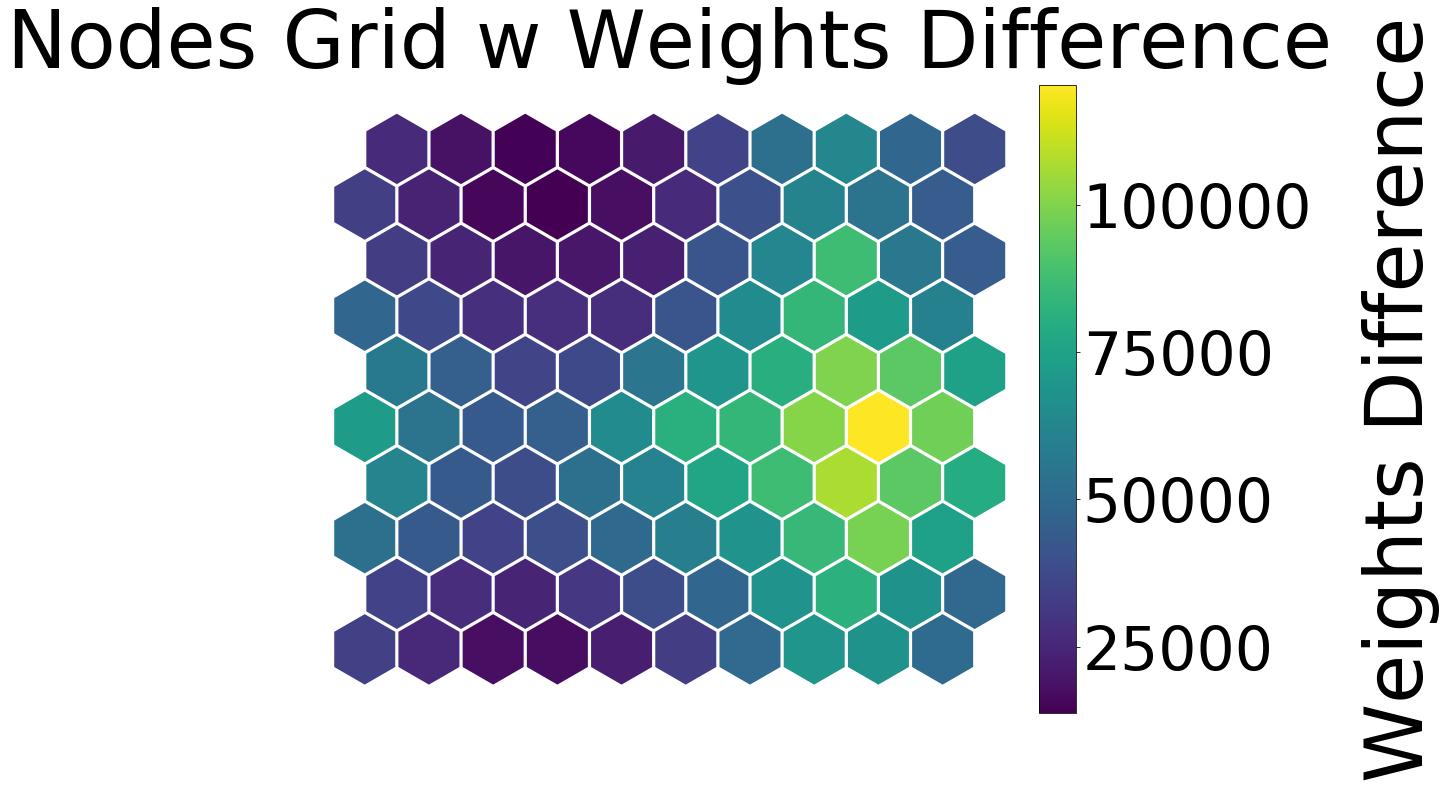

[[8.5, 0.8660254037844388],
 [2.5, 7.794228634059948],
 [3, 6.9282032302755105],
 [6, 0.0],
 [1, 3.4641016151377553],
 [3, 5.196152422706632],
 [2.5, 7.794228634059948],
 [1.5, 7.794228634059948],
 [3, 6.9282032302755105],
 [2.5, 7.794228634059948],
 [2, 0.0],
 [8, 1.7320508075688776],
 [1.5, 0.8660254037844388],
 [0.5, 0.8660254037844388],
 [1, 3.4641016151377553],
 [3.5, 6.062177826491071],
 [6.5, 6.062177826491071],
 [3.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [3.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [8, 1.7320508075688776],
 [8.5, 0.8660254037844388],
 [5.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [3, 5.196152422706632],
 [1.5, 4.330127018922194],
 [7.5, 2.598076211353316],
 [7, 1.7320508075688776],
 [2, 6.9282032302755105],
 [4.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [2.5, 7.794228634059948]]

<Figure size 432x288 with 0 Axes>

In [19]:
X= X_train.to_numpy()
#Build a network 20x20 with a weights format taken from the raw_data and activate Periodic Boundary Conditions. 
net = sps.somNet(10,10, X, PBC=True)

#Train the network for 10000 epochs and with initial learning rate of 0.01. 
net.train(0.01, 1000)

#Print a map of the network nodes and colour them according to the first feature (column number 0) of the dataset
#and then according to the distance between each node and its neighbours.
net.diff_graph(show=True,printout=False)

#Project the datapoints on the new 2D network map.
net.project(X_test.to_numpy(), labels=y_test.to_numpy())

#Cluster the datapoints according to the Quality Threshold algorithm.
#net.cluster(X, type='qthresh')

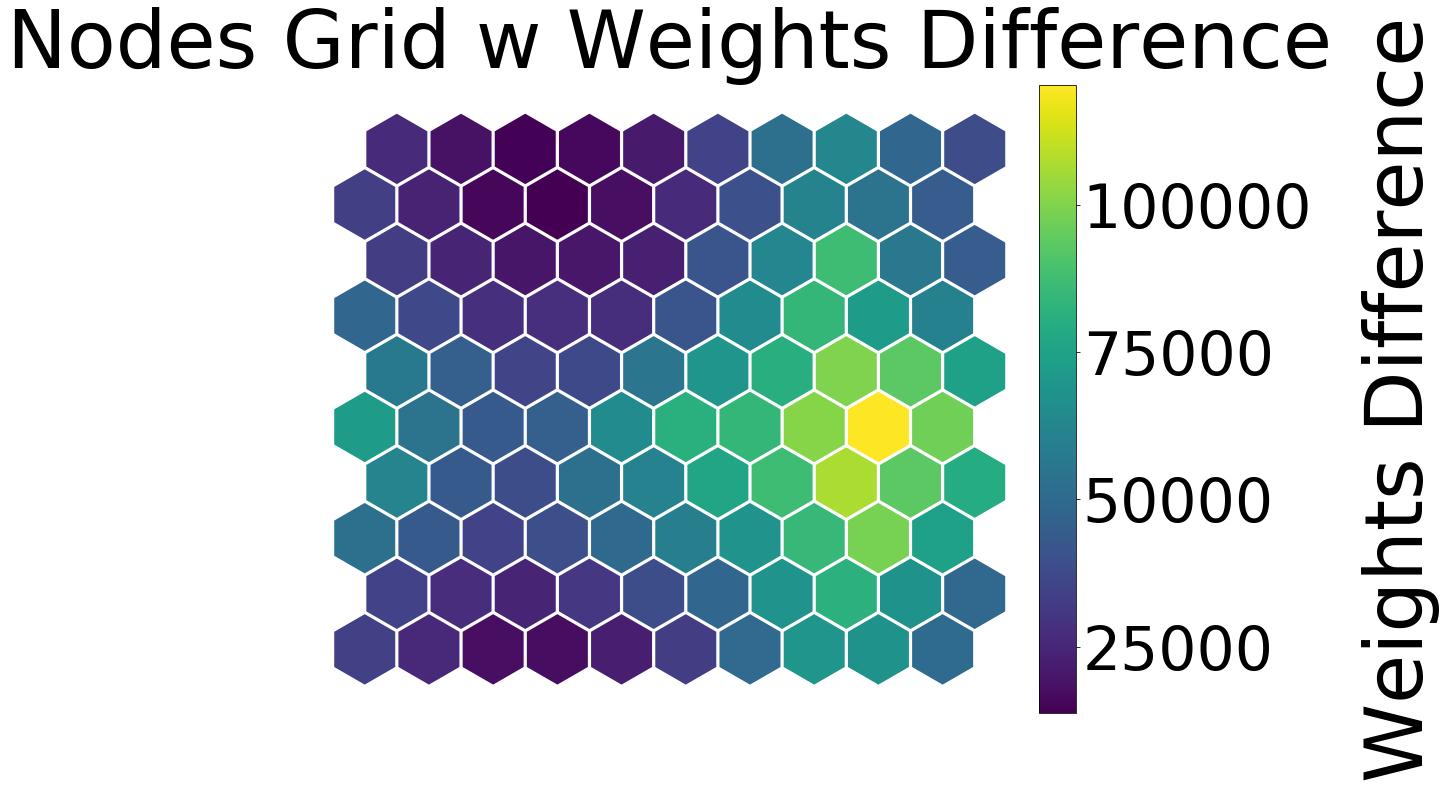

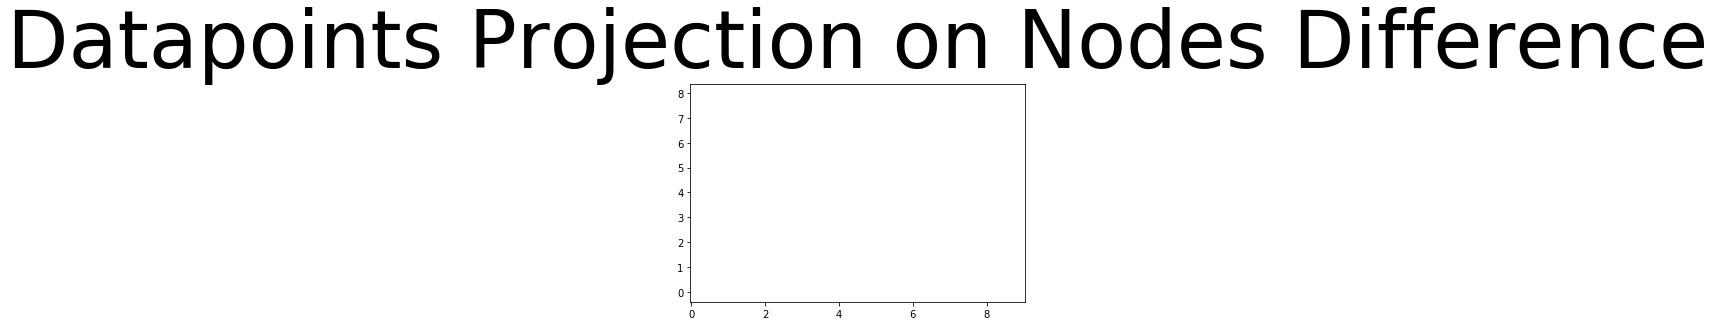

[[8.5, 0.8660254037844388],
 [2.5, 7.794228634059948],
 [3, 6.9282032302755105],
 [6, 0.0],
 [1, 3.4641016151377553],
 [3, 5.196152422706632],
 [2.5, 7.794228634059948],
 [1.5, 7.794228634059948],
 [3, 6.9282032302755105],
 [2.5, 7.794228634059948],
 [2, 0.0],
 [8, 1.7320508075688776],
 [1.5, 0.8660254037844388],
 [0.5, 0.8660254037844388],
 [1, 3.4641016151377553],
 [3.5, 6.062177826491071],
 [6.5, 6.062177826491071],
 [3.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [3.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [8, 1.7320508075688776],
 [8.5, 0.8660254037844388],
 [5.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [3, 5.196152422706632],
 [1.5, 4.330127018922194],
 [7.5, 2.598076211353316],
 [7, 1.7320508075688776],
 [2, 6.9282032302755105],
 [4.5, 6.062177826491071],
 [2.5, 7.794228634059948],
 [2.5, 7.794228634059948]]

<Figure size 432x288 with 0 Axes>

In [24]:
%matplotlib inline
net.diff_graph(show=True)

#Project the datapoints on the new 2D network map.
net.project(X_test.to_numpy(),show=True)

# XGBoost

In [40]:
def objective_xgb(hyperparameters,X,y,trainfolds):
    """Objective function for xgboost"""
    xgbmodel = xgb.XGBClassifier(objective="binary:logistic").set_params(**hyperparameters)
    
    score = cross_val_score(xgbmodel,X,y,cv=trainfolds,scoring="accuracy",n_jobs = -1)
    best_score = score.mean()
    loss = 1-best_score
    return {"loss":loss,"params":hyperparameters,"status":STATUS_OK}

In [76]:
def xgb_bcv(*args,X,y,trainfolds):
    trainfoldlist = list(trainfolds)
    bayes_trials = Trials() 
    MAX_EVALS = 100
    # Define the search space
    space = {
    'n_estimators': hp.choice('n_estimators', [100, 300,500]),
    'booster': "gbtree",
    "subsample" : hp.uniform("subsample",0.7,1),#hp.choice('booster', 
#                                [{'booster': 'gbtree', 
#                                     'subsample': hp.uniform('gbtree_subsample', 0.5, 1)}, 
#                                  {'booster': 'gblinear', 
#                                      'subsample': hp.uniform('gblinear_subsample', 0.5, 1)}]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'min_child_weight': hp.quniform('min_child_weight', 1,20,1),
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    "gamma": hp.uniform("gamma",0,2),
     "max_delta_step":hp.quniform("max_delta_step", 0,3,1),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

    # Optimize
    best = fmin(fn =lambda x: objective_xgb(x,X=X,y=y,trainfolds=trainfoldlist), space = space, algo = tpe.suggest, 
                max_evals = MAX_EVALS, trials = bayes_trials)
    model =xgb.XGBClassifier().set_params(**best).fit(X,y)
    
    return(best,model,[])

In [ ]:
def xgb_cv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(objective="binary:logistic",learning_rate=0.2),
        param_grid={
            'max_depth': range(1,3),
            'n_estimators': [500,600],
            "min_child_weight":range(1,3)
            #"reg_alpha":[0,0.3,0.7,1],
            #"reg_lambda":[0,0.3,0.7,1]
            
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [55]:
def xgb_rcv(X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(objective="binary:logistic",n_estimators=500),random_state = 42,
        param_distributions={
            'max_depth': range(2,4),
            "min_child_weight":range(1,3),
            "gamma": st.uniform(loc=0,scale=1),
            "reg_alpha":st.uniform(loc=0,scale =1),
            "reg_lambda":st.uniform(loc=0,scale=1)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False,n_iter = 200)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [79]:
index = ["RIVER"]
xsetlist = [riverdfCssLog]
ysetlist = [wwfdf.Water]
ygrouplist = [wwfdf.Area_group]
dis_xgb_csslog=mth.runningsplittest(GroupKFold,model_cv=xgb_bcv,index=index,xsetlist=xsetlist,ysetlist=ysetlist,ygrouplist = ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 100/100 [07:55<00:00,  5.02s/it, best loss: 0.07232142857142854]
[[13  0]
 [19  0]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 100/100 [09:36<00:00,  6.05s/it, best loss: 0.12127976190476186]
[[ 0  0]
 [ 1 31]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 100/100 [09:46<00:00,  6.20s/it, best loss: 0.109375]          
[[ 0  2]
 [19  7]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 100/100 [05:58<00:00,  3.61s/it, best loss: 0.11086309523809523]
[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pa

/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


100%|██████████| 100/100 [05:33<00:00,  3.32s/it, best loss: 0.12127976190476186]
[[ 0  1]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 100/100 [05:46<00:00,  3.07s/it, best loss: 0.08794642857142854]
[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 100/100 [05:48<00:00,  3.61s/it, best loss: 0.11086309523809523]
[[ 0  0]
 [ 0 12]]


/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
# index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
index = ["OTU CSS LOG"]
xsetlist = [otudfCssLog]
ysetlist = [wwfdf]

dissim_xgb_grid =runningsplittest(GroupKFold,xgb_cv,index,xsetlist,ysetlist)

# KNN

In [ ]:
def knn_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    print(args)
    knnmetric = args[0]["metric"]
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=KNeighborsClassifier(metric=knnmetric),
        param_grid={
        "n_neighbors": range(1,30),
       #,"braycurtis"],
            "weights":["uniform","distance"],
            "p": range(1,6)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    

    return (best_params,grid_result,None)

In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

dis_knn_min_grid_fish =runningsplittest(GroupKFold,knn_cv,index,xsetlist,ysetlist,metric="minkowski")

In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_min_grid_fish =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist,knnmetric="minkowski")

In [ ]:
def test(a,b,**kwarg):
    test2(kwarg,w=a)
def test2(*args,w):
    print(w,args[0])


In [ ]:
test(a=1,b= 4,metric=5)

In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_min_grid =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist)

In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_bray_grid =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist)

In [ ]:
dataset =dissim_knn_min_grid
print(dataset.Confusion)
print("\n")
print(dataset.Parameters[0])

In [ ]:
sim_knn_bray_grid.to_pickle("sim_knn_bray_grid")
#sim_knn_min_grid.to_pickle("sim_knn_min_grid")

# BART

In [ ]:
 pctrain,pctest,ytrain,ytest= train_test_split(pcoaOtu,wwfdf.Water,test_size = 0.2)
ytrain =(ytrain =="White")*1
ytest =(ytest =="White")*1

In [ ]:
model = SklearnModel() # Use default parameters
model.fit(pctrain, ytrain) # Fit the model
#predictions = model.predict() # Make predictions on the train set
#out_of_sample_predictions = model.predict(X_test) # Make predictions on new data

# Parts of Rivers as labels

Changing labels of prediction to parts of river. So we have a multiclass problem

Trying KNN. We will be using the methods files

In [79]:
mth = importlib.reload(methods)

In [81]:
index = ["OTU","OTU CSS","OTU CSS LOG"]
xsetlist = [otudf,otudfCss,otudfCssLog]
ysetlist =[wwfdf.river_label,wwfdf.river_label,wwfdf.river_label]
# mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.knn_cv,xsetlist=xsetlist,ysetlist=ysetlist)
riv_knn_bray = mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=knn_cv,xsetlist=xsetlist,ysetlist=ysetlist,metric="braycurtis")

0
Same CV generator as train-test split
0
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:   10.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [2 0 6 3]
 [3 0 0 3]]
1
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[2 0 0 1]
 [0 4 0 0]
 [1 0 9 1]
 [0 0 0 6]]
2
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 4 7 0]
 [1 0 1 4]]
3
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [3 0 5 3]
 [3 0 1 2]]
4
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[1 0 0 2]
 [0 3 0 0]
 [0 0 7 4]
 [0 0 0 6]]
5
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 2  0  1  3]]
6
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
1
Same CV generator as train-test split
0
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 0 8 3]
 [0 0 0 6]]
1
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[ 2  0  1  0]
 [ 0  1  3  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
2
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[2 0 1 0]
 [0 4 0 0]
 [0 4 7 0]
 [1 0 1 4]]
3
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 2 8]
 [3 0 1 2]]
4
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 6 5]
 [0 0 1 5]]
5
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    8.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[ 0  0  1  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
2
Same CV generator as train-test split
0
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 3 1 0]
 [0 0 4 7]
 [0 0 0 6]]
1
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 0 9 2]
 [0 0 0 6]]
2
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 4 4]
 [2 0 0 4]]
3
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[0 0 3 0]
 [0 3 0 0]
 [1 0 6 4]
 [0 0 2 4]]
4
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 1 5]]
5
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  0  6]]
6
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.8s


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  0  6]]


[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    7.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Random Forrest 

In [84]:
index = ["OTU","OTU CSS","OTU CSS LOG"]
xsetlist = [otudf,otudfCss,otudfCssLog]
ysetlist =[wwfdf.river_label,wwfdf.river_label,wwfdf.river_label]
# mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.knn_cv,xsetlist=xsetlist,ysetlist=ysetlist)
riv_rf = mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.rfr_cv,xsetlist=xsetlist,ysetlist=ysetlist)

0
Same CV generator as train-test split
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 2 0]
 [0 0 4 0]
 [0 0 8 3]
 [0 0 3 3]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 3  0  0  0]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  5  1]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [0 0 4 2]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   34.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  1  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   29.3s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0  0  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.0s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   34.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
1
Same CV generator as train-test split
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   33.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 2 0]
 [0 0 4 0]
 [0 0 9 2]
 [0 0 3 3]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  0  1]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  6  0]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   33.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [1 0 1 4]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.9s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  1  0]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  5  1]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   38.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0  2  1]
 [ 0  2  1  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
2
Same CV generator as train-test split
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 2 0]
 [0 0 4 0]
 [0 0 9 2]
 [0 0 3 3]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.8s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  0  1]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  6  0]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.4s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [1 0 1 4]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   31.0s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.5s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.1s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.5s


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]


[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   30.6s finished
/home/spanashis/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Opening dataframes

In [ ]:
dissim_log_df =pd.read_pickle("dis_log")
dissim_rfr_df = pd.read_pickle("dis_rfr")
sim_log_df = pd.read_pickle("sim_log")
sim_rfr_df= pd.read_pickle("sim_rf")
rand_rfr_df = pd.read_pickle("rand_rfr")
rand_log_df = pd.read_pickle("rand_log")
sim_logl2_df =pd.read_pickle("sim_logl2_df")
dissim_logl2_df =pd.read_pickle("dissim_logl2_df")
dissim_knn_bray_grid = pd.read_pickle("dissim_knn_bray_grid")
dissim_knn_min_grid = pd.read_pickle("dissim_knn_min_grid")
sim_knn_min_grid = pd.read_pickle("sim_knn_min_grid")
sim_knn_bray_grid = pd.read_pickle("sim_knn_bray_grid")

In [ ]:
dissim_baysl2 = pd.read_pickle("dissim_baysl2")

In [ ]:
def printoutdataframe(dataframe):
    for j,i in enumerate(dataframe.Confusion):
        print(dataframe.index[j])
        print(i)
        acc = (i[0,0]+i[1,1])/i.sum()
        print(round(acc,4))

In [82]:
def riverslabelvisualisation(dataframe):
    """
    Input:
    Dataframe: A pandas dataframe of results from runningsplittest
    Output:
    A plot of confusion matrix"""
    sns.set(font_scale=1.4)#for label size
    for j,i in enumerate(dataframe.Confusion):
        print(dataframe.index[j])
    
        df_cm = pd.DataFrame(i, index = ["Black","UMar","MLMar,Uc","Tap,Nap,Hua"],
                             columns=["Black","UMar","MLMar,Uc","Tap,Nap,Hua"])
        #plt.figure(figsize = (10,7))
        plt.title(dataframe.index[j])
        sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap =sns.cm.rocket_r)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

In [ ]:
def zero_params(x):
    zeroes =[]
    for i in x:
        zeroes.append((i == 0).sum()/i.shape[1] )
    zeroes = np.array(zeroes).mean()
    return(zeroes)
dataframe = dissim_log_df
dataframe.Coefficients.apply(lambda x:zero_params(x))
    

In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG"]

acv_coef =[]
for k in range(7):
    first_coef =[]
    for i in dissim_log_df.Coefficients[index]:
        #print(i)
        first_coef.append((i[k]==0.0)*1)
    commonz=[]  
    for j in range(first_coef[0].shape[1]):

        commonz.append(np.all(first_coef[0][0,j] == first_coef[1][0,j]==first_coef[2][0,j] == 0))
    acv_coef.append( np.array(commonz).mean())
np.array(acv_coef).mean()


In [ ]:
dataframe = dissim_baysl2

for j,i in enumerate(dataframe.Confusion):
    print(dataframe.index[j])
    print(i)
    acc = (i[0,0]+i[1,1])/i.sum()
    print(round(acc,4))

## LR

In [ ]:
display(Markdown("### LR DIS"))
printoutdataframe( dis_logl2_fish)

In [ ]:
display(Markdown("### LR SIM "))
printoutdataframe( sim_logl2_fish)

## RFR

In [ ]:
display(Markdown("### RFR DIS"))
printoutdataframe( dis_rfr_fish)

In [ ]:
display(Markdown("### RFR SIM"))
printoutdataframe( sim_rfr_fish)

## KNN

In [ ]:
display(Markdown("### KNN minkowski DIS"))
printoutdataframe( dis_knn_min_grid_fish)

In [ ]:
display(Markdown("### KNN minkowski SIM"))
printoutdataframe( sim_knn_min_grid_fish)

In [ ]:
display(Markdown("### KNN braycurtis DIS"))
printoutdataframe( dissim_knn_bray_grid)

In [ ]:
display(Markdown("### KNN bray SIM"))
printoutdataframe( sim_knn_min_grid)

OTU


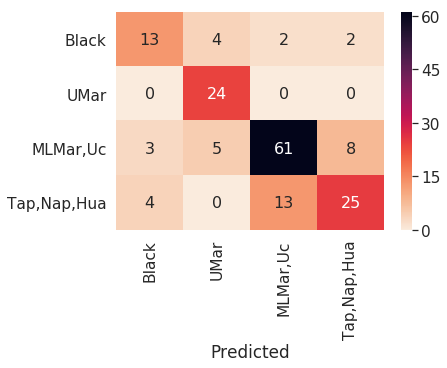

OTU CSS


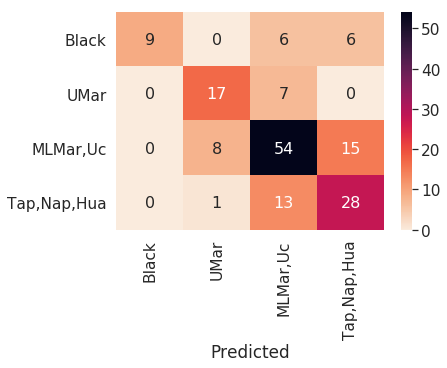

OTU CSS LOG


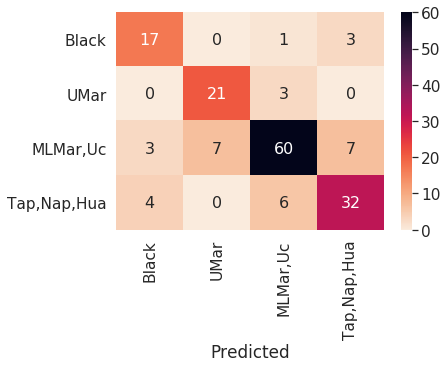

In [44]:
riverslabelvisualisation(riv_knn)

knn bray

OTU


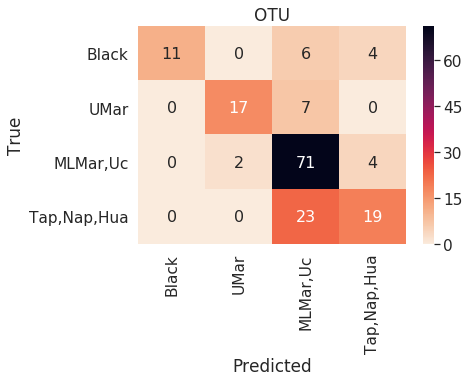

OTU CSS


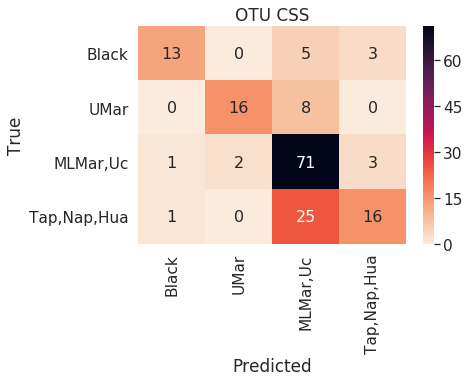

OTU CSS LOG


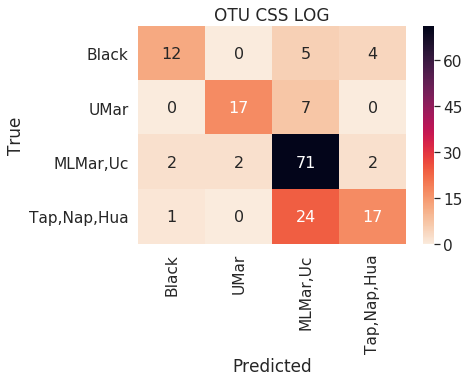

In [85]:
riverslabelvisualisation(riv_rf)

# Taxa exploration

In [ ]:
index_of_coefficients =np.argsort(similarity_rfr_df.Coefficients["OTU"])
meancoefficients =np.array(similarity_rfr_df.Coefficients["OTU"]).mean(axis =0)
taxadf["Coefficients"] = meancoefficients
sum_per_class =taxadf.groupby(by = "Order").mean().sum()
(taxadf.groupby(by = "Order").mean()/sum_per_class).plot.pie(y = "Coefficients",figsize =(10,10))

In [ ]:
#dataframe = diffsimilarity_rfr_df
def scaledtaxamethod(dataframe,taxon_level="Order",taxa = taxadf,index = ["OTU","OTU CSS","OTU MIN CSS","OTU CSS LOG"]):
    """
    Input
    dataframe: Dataframe from runningsplittest method
    """
    #taxon_level = "Order"
    taxa_dataf = taxa.copy()
    # get index of dataframe
    index = dataframe.index
    for i in index:
        mean_of_folds =np.abs(np.array(dataframe.Coefficients[i])).mean(axis =0)
        print(mean_of_folds.shape)
        taxa_dataf[i] = mean_of_folds
    # To change aggregate change the mean taxa by level. If its set to sum then it sums, if mean then the average is found
    mean_taxa_by_level = taxa_dataf.groupby(by=taxon_level).sum()
    scaled_taxa_by_level =mean_taxa_by_level/mean_taxa_by_level.sum()
    return(scaled_taxa_by_level)

In [ ]:
%matplotlib inline
def func(pct):
    if pct >=5:
        return "{:.1f}%".format(pct)
    else:
        return("")
def pieplots(scaled_taxa,ax_titles,filenameprefix):
    shape_of_df = scaled_taxa.shape
    colord =20
    scaled_taxa_by_level_color = np.arange(0,shape_of_df[0])%colord
    col_to_plot =scaled_taxa.columns
    #ax_titles = ["Similarity OTU","Similarity OTU CSS", "Similarity OTU MIN CSS","Dissimilarity OTU","Dissimilarity OTU CSS", "Dissimilarity OTU MIN CSS"]
    #fig,axes = plt.subplots(nrows = 3,ncols=2,figsize=(20,30))
    
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0,1,colord)]
    plt.rcParams.update({'font.size': 20})

    #axes.set_color_cycle(colors)
    for i,j in enumerate(col_to_plot):
        print(j)
        #ax = axes[i%3,i//3]
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        sortedindx = np.argsort(scaled_taxa[j])
        sortedcolor = [colors[k] for k in scaled_taxa_by_level_color[sortedindx]]
        sortedlabels =scaled_taxa.index[sortedindx].values
        sortedlabels[0:-6] =""
        ax.pie(x = scaled_taxa[j][sortedindx],labels=sortedlabels,colors=sortedcolor,startangle=30, autopct=lambda pct: func(pct))
        ax.set_title(ax_titles[i],fontsize = 20)
        fig.savefig(fname=filenameprefix+j+".png",transparent=True,dpi=300)
        #scaled_taxa_by_level.plot.pie(y=i,legend =False,figsize=(10,10))
    #fig.suptitle(figure_title,fontsize=22,y=0.93)   
    #fig.subplots_adjust(wspace=0.01)
    #fig.savefig(figure_name,transparent=True,dpi = 300)

In [ ]:
col_to_plot = ["Dissimilarity Fish","Dissimilarity Fish CSS",
               "Dissimilarity Fish CSS LOG"]
#scaledtaxamethod(dissim_rfr_df)
pieplots(scaledtaxamethod(dis_rfr_fish,taxa=taxadf.loc[fishdf.columns]),col_to_plot,"rfr_dis_fish_sum_pie")

In [ ]:
sim_log_df

In [ ]:
col_to_plot=["Similarity OTU","Similarity OTU CSS","Similarity OTU MIN CSS"]
pieplots(scaled_taxa_by_level,None,"rfr_order_pie")

In [ ]:
scaled_taxa = taxadf.groupby("Order").count()
shape_of_df = scaled_taxa.shape
scaled_taxa_by_level_color = np.arange(0,shape_of_df[0])%10
col_to_plot =[scaled_taxa.columns[0]]
#ax_titles = ["Similarity OTU","Similarity OTU CSS", "Similarity OTU MIN CSS","Dissimilarity OTU","Dissimilarity OTU CSS", "Dissimilarity OTU MIN CSS"]
#fig,axes = plt.subplots(nrows = 3,ncols=2,figsize=(20,30))

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0,1,10)]
plt.rcParams.update({'font.size': 15})

#axes.set_color_cycle(colors)
for i,j in enumerate(col_to_plot):
    #ax = axes[i%3,i//3]
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    sortedindx = np.argsort(scaled_taxa[j])
    sortedcolor = [colors[k] for k in scaled_taxa_by_level_color[sortedindx]]
    sortedlabels =scaled_taxa.index[sortedindx].values
    sortedlabels[0:-6] =""
    ax.pie(x = scaled_taxa[j][sortedindx],labels=sortedlabels,colors=sortedcolor,startangle=30
          ,autopct=lambda p:  '{:.0f}'.format(p * 675 / 100) if p >= 2.90 else "")
    ax.set_title("Order distribution",fontsize = 20)
    fig.savefig(fname="orderdistrpie.png",transparent=True,dpi=300)